### 1)

In [1]:
! pip install torch
! pip install umap-learn
! pip install cleverhans
! pip install pytorch-metric-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 3.2 MB/s eta 0:00:00


In [2]:
import torch    
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.models as models
from tqdm import tqdm
import umap
from pytorch_metric_learning import losses,miners,samplers
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
import torch.nn as nn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import random
torch.manual_seed(42)
print('Is CUDA available', torch.cuda.is_available())
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))

Is CUDA available True
Torch 1.13.0 CUDA 11.3
Device: cuda:0


In [3]:
class Resnet18(nn.Module):
    def __init__(self, num_classes,normalize = False):
        super().__init__()
        self.model = models.resnet18(weights=None)
        self.fc = nn.Linear(1000,num_classes, bias=False)
        self.backbone = torch.nn.Sequential(*list(self.model.children())[:-2])
        self.normalize = normalize

    def forward(self, x):
        out = self.model(x)
        out = self.fc(out)
        if(self.normalize):
            out = torch.nn.functional.normalize(out)
        return out

In [4]:
class Cifar10Dataset(torch.utils.data.Dataset):

    def __init__(self,dataset,idx,transforms=None):
        self.idx = idx
        self.transforms = transforms
        self.data = torch.utils.data.Subset(dataset, idx)

    def __getitem__(self,index):
        image,label = self.data[index]
        if(self.transforms!= None):
            image = self.transforms(image)

        return image,label

    def __len__(self):
        return len(self.data)

In [5]:
TEST_SIZE = 0.8
BATCH_SIZE = 200
SEED = 42
data_statistics = ((0.5,0.5,0.5),(0.5,0.5,0.5))
cifar_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize(*data_statistics,inplace = True)])
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

cifar_dataset = torch.utils.data.ConcatDataset([cifar_trainset, cifar_testset])
targets = [label for image,label in cifar_dataset]
train_idx, test_idx = train_test_split(np.arange(len(targets)),test_size=0.8,shuffle=True,stratify=targets,random_state=SEED)
train_dataset = Cifar10Dataset(cifar_dataset,train_idx,cifar_transforms)
test_dataset = Cifar10Dataset(cifar_dataset,test_idx,cifar_transforms)
train_classes = [label for _, label in train_dataset]
print("train:",Counter(train_classes))
test_classes = [label for _, label in test_dataset]
print("test:",Counter(test_classes))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle= True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
train: Counter({6: 1200, 9: 1200, 4: 1200, 0: 1200, 7: 1200, 5: 1200, 8: 1200, 2: 1200, 3: 1200, 1: 1200})
test: Counter({3: 4800, 0: 4800, 4: 4800, 9: 4800, 1: 4800, 6: 4800, 5: 4800, 7: 4800, 8: 4800, 2: 4800})


torch.Size([3, 32, 32])


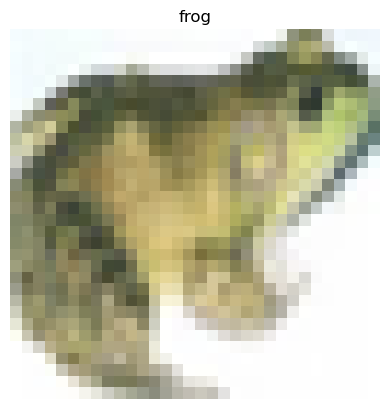

In [ ]:
img, label = train_dataset[0]
print(img.shape)
img = img*0.5+0.5
plt.imshow(img.permute(1, 2, 0))
plt.title(classes[label])
plt.axis("off")
plt.show()

### 2)

In [6]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def angular_acc(data, target, model, embeded):
    model.eval()
    target_array = target.cpu().numpy()
    master_features = [] 
    pred_ = []
    classes = ["0","1","2","3","4","5","6","7","8","9"]
    for i in classes:
        indexes = np.where(target_array==int(i))[0]
        if len(indexes)==0:
            continue
        master_img = data[np.random.choice(indexes)].to(device)
        master_img = torch.unsqueeze(master_img, dim=0)
        master_img = master_img.to(device)
        embedded_master_img = model(master_img)
        master_features.append(embedded_master_img)
    master_features = torch.cat(master_features) # (10, 128)
    output_unbind = torch.unbind(embeded)
    for embedded_img in output_unbind:
        distances = torch.sum((master_features - embedded_img)**2, dim=1) #(10)F.pairwise_distance(master_features, embedded_img, 2)#
        pred_category = classes[distances.argmin()]
        pred_.append(int(pred_category))

    pred_category = torch.LongTensor(pred_).to(device)
    correct = (target == pred_category).sum().item()
    return correct

In [8]:
def KNN_accuracy(model,knnmodel,xtest,ytest):
    #train_map = model(xtrain)
    test_map = model(xtest)
    #knn = KNeighborsClassifier(n_neighbors=10)
    #knn.fit(train_map.cpu().detach().numpy(),y_train)# Predicting results using Test data set
    ytest = ytest.cpu().detach().numpy()
    pred = knnmodel.predict(test_map.cpu().detach().numpy())
    correct = (pred == ytest).sum()
    return correct

In [9]:
def train(model,data_loader,criterion,optimizer,attack = False,miner_func = None,angular_loss = False):
    
    train_loss = 0
    correct = 0
    total = 0
    with tqdm(data_loader, desc ="   train") as train_tqdm:
        for batch_idx, (inputs, targets) in enumerate(train_tqdm):
            model.train()
            inputs, targets = inputs.to(device), targets.to(device)
            if(attack and random.uniform(0,1)>0.6):
                inputs = fast_gradient_method(model,inputs,0.1, np.inf)
            optimizer.zero_grad()
            outputs = model(inputs)
            if(miner_func != None):
                miner_output = miner_func(outputs, targets)
                loss = criterion(outputs, targets, miner_output)
            else:
                loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            if(angular_loss):
                correct += angular_acc(inputs, targets, model, outputs)
            else:
                _, predicted = outputs.max(1)
                correct += predicted.eq(targets).sum().item()

            total += targets.size(0)
            train_tqdm.set_postfix(accuracy=100.*correct/total, loss=train_loss/total,total = total,refresh=True)
          #print(batch_idx+1, len(data_loader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)' % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
      
      #train_loss = train_loss/(total*len(data_loader))
      #train_acc = correct/(total*len(data_loader))
    return train_loss/total,100.*correct/total

In [74]:
def test(model,data_loader,criterion,optimizer,attack=False,miner_func = None,angular_loss = False,knnmodel = None):
    #global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for batch_idx, (inputs, targets) in enumerate(test_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)
            if(attack and random.uniform(0,1)>0.6):
                inputs = fast_gradient_method(model,inputs,0.1, np.inf)
            outputs = model(inputs)
            #outputs = torch.nn.functional.normalize(outputs, p=2.0, dim = 0)
            if(miner_func != None):
                miner_output = miner_func(outputs, targets)
                loss = criterion(outputs, targets, miner_output)
            else:
                loss = criterion(outputs, targets)


            test_loss += loss.item()
            if(angular_loss):
                correct +=  angular_acc(inputs, targets, model, outputs)
            else:
                _, predicted = outputs.max(1)
                correct += predicted.eq(targets).sum().item()
          
            total += targets.size(0)

            test_tqdm.set_postfix(accuracy=100.*correct/total, loss=test_loss/total,total = total, refresh=True)
            
        #test_loss = test_loss/(total*len(data_loader))
        #test_acc = correct/(total*len(data_loader))
    return test_loss/total,100.*correct/total

In [11]:
def train_model(model,trainloader,loss_fn,optimizer,attack = False,epochs = 80,miner_func = None,angular_loss = False):
    
    train_epoch_loss = []
    train_epoch_accuracy = []
    for epoch in range(epochs):
        print("EPOCH {}/{} :".format(epoch +1, epochs))
        train_loss, train_acc = train(model = model ,
                                    data_loader=trainloader,
                                    criterion = loss_fn,
                                    optimizer=optimizer,
                                    attack = attack,
                                    miner_func = miner_func,
                                    angular_loss = angular_loss)
      
        train_epoch_loss.append(train_loss)
        train_epoch_accuracy.append(train_acc)
        
    return train_epoch_loss,train_epoch_accuracy


In [12]:
def draw_loss_accuracy(train_loss,train_accuracy,test_loss,test_accuracy):
    num_epochs = len(train_loss)
    epochs = [i for i in range(0,num_epochs,2)]
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(train_loss, 'r', label='Train')
    plt.plot(test_loss , 'g', label='Test')
    plt.xlabel('Epochs')
    plt.xticks(epochs)
    plt.title('Loss')
    plt.legend()
    plt.subplot(122)
    plt.plot(train_accuracy, 'r', label='Train')
    plt.plot(test_accuracy, 'g', label='Test')
    plt.xlabel('Epochs')
    plt.xticks(epochs)
    plt.title('Accuracy')
    #plt.tight_layout(pad=3)
    plt.legend()
    plt.show();

In [13]:
classes = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
def plot_umap(features,y):
    umap_ = umap.UMAP(n_neighbors=10, min_dist=0.3, n_components=2)
    components = umap_.fit_transform(features)
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot()
    for key, value in enumerate(classes):
        umap_class = []
        for i in range(len(components)):
            if y[i] == key:
                umap_class.append(components[i])
        umap_class = np.array(umap_class)
        ax.scatter(umap_class[:, 0], umap_class[:, 1], alpha=0.8, label=value)

    ax.legend(loc='upper left', ncol=3)
    plt.title('UMAP')
    plt.xlabel("1st Component"); 
    plt.ylabel("2nd Component")
    plt.show()

In [46]:
resnet18 = Resnet18(10,False)
resnet18 = resnet18.to(device)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
train_model(resnet18,trainloader,loss_func,optimizer);

EPOCH 1/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 13.92it/s, accuracy=31.9, loss=0.00958, total=12000]


EPOCH 2/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 12.53it/s, accuracy=46.6, loss=0.0074, total=12000] 


EPOCH 3/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.47it/s, accuracy=54.8, loss=0.00635, total=12000]


EPOCH 4/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.72it/s, accuracy=60.1, loss=0.00567, total=12000]


EPOCH 5/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.74it/s, accuracy=65, loss=0.00495, total=12000]  


EPOCH 6/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.36it/s, accuracy=70.4, loss=0.00426, total=12000]


EPOCH 7/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.61it/s, accuracy=74.9, loss=0.0036, total=12000] 


EPOCH 8/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.43it/s, accuracy=79.1, loss=0.00307, total=12000]


EPOCH 9/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 12.74it/s, accuracy=83, loss=0.00245, total=12000]  


EPOCH 10/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.83it/s, accuracy=85.3, loss=0.00214, total=12000]


EPOCH 11/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.15it/s, accuracy=87, loss=0.00191, total=12000]  


EPOCH 12/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.57it/s, accuracy=89.7, loss=0.00145, total=12000]


EPOCH 13/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.83it/s, accuracy=91.4, loss=0.00121, total=12000]


EPOCH 14/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.34it/s, accuracy=92.6, loss=0.00105, total=12000]


EPOCH 15/80 :


   train: 100%|██████████| 60/60 [00:03<00:00, 15.09it/s, accuracy=93.5, loss=0.000935, total=12000]


EPOCH 16/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.40it/s, accuracy=94.4, loss=0.000826, total=12000]


EPOCH 17/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 12.94it/s, accuracy=95.7, loss=0.000652, total=12000]


EPOCH 18/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.91it/s, accuracy=95.1, loss=0.000718, total=12000]


EPOCH 19/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.37it/s, accuracy=95.6, loss=0.000659, total=12000]


EPOCH 20/80 :


   train: 100%|██████████| 60/60 [00:03<00:00, 15.00it/s, accuracy=96.5, loss=0.000522, total=12000]


EPOCH 21/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.88it/s, accuracy=97.5, loss=0.000359, total=12000]


EPOCH 22/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.37it/s, accuracy=96.9, loss=0.000447, total=12000]


EPOCH 23/80 :


   train: 100%|██████████| 60/60 [00:03<00:00, 15.00it/s, accuracy=96.3, loss=0.000549, total=12000]


EPOCH 24/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 12.76it/s, accuracy=97.2, loss=0.000415, total=12000]


EPOCH 25/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.34it/s, accuracy=97.9, loss=0.000333, total=12000]


EPOCH 26/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.56it/s, accuracy=98.2, loss=0.000272, total=12000]


EPOCH 27/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.34it/s, accuracy=97.8, loss=0.000327, total=12000]


EPOCH 28/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.73it/s, accuracy=98.1, loss=0.000289, total=12000]


EPOCH 29/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.26it/s, accuracy=98.2, loss=0.000275, total=12000]


EPOCH 30/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.89it/s, accuracy=98, loss=0.000295, total=12000] 


EPOCH 31/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.43it/s, accuracy=97.9, loss=0.000307, total=12000]


EPOCH 32/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 12.69it/s, accuracy=97.8, loss=0.000338, total=12000]


EPOCH 33/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.76it/s, accuracy=97.8, loss=0.000337, total=12000]


EPOCH 34/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.96it/s, accuracy=97.5, loss=0.000365, total=12000]


EPOCH 35/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.33it/s, accuracy=98, loss=0.000286, total=12000]  


EPOCH 36/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.82it/s, accuracy=97.7, loss=0.000356, total=12000]


EPOCH 37/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.27it/s, accuracy=98.6, loss=0.000215, total=12000]


EPOCH 38/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.79it/s, accuracy=98.5, loss=0.000213, total=12000]


EPOCH 39/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.22it/s, accuracy=98.2, loss=0.000268, total=12000]


EPOCH 40/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 13.00it/s, accuracy=98.2, loss=0.000267, total=12000]


EPOCH 41/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.86it/s, accuracy=98.4, loss=0.000246, total=12000]


EPOCH 42/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.90it/s, accuracy=98, loss=0.000337, total=12000]  


EPOCH 43/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.28it/s, accuracy=97.6, loss=0.000344, total=12000]


EPOCH 44/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.80it/s, accuracy=98.4, loss=0.000245, total=12000]


EPOCH 45/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.25it/s, accuracy=98.2, loss=0.000266, total=12000]


EPOCH 46/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.80it/s, accuracy=99, loss=0.000164, total=12000]  


EPOCH 47/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 12.77it/s, accuracy=98.6, loss=0.000206, total=12000]


EPOCH 48/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.34it/s, accuracy=98.5, loss=0.000232, total=12000]


EPOCH 49/80 :


   train: 100%|██████████| 60/60 [00:03<00:00, 15.01it/s, accuracy=98.3, loss=0.000253, total=12000]


EPOCH 50/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.25it/s, accuracy=98.2, loss=0.000278, total=12000]


EPOCH 51/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.87it/s, accuracy=98.2, loss=0.000254, total=12000]


EPOCH 52/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.74it/s, accuracy=98.3, loss=0.000264, total=12000]


EPOCH 53/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.26it/s, accuracy=98.3, loss=0.000267, total=12000]


EPOCH 54/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.94it/s, accuracy=98.3, loss=0.00024, total=12000] 


EPOCH 55/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 12.81it/s, accuracy=98.8, loss=0.000178, total=12000]


EPOCH 56/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.54it/s, accuracy=98.2, loss=0.000253, total=12000]


EPOCH 57/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.81it/s, accuracy=98.1, loss=0.000287, total=12000]


EPOCH 58/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.29it/s, accuracy=98.4, loss=0.000257, total=12000]


EPOCH 59/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.60it/s, accuracy=98.1, loss=0.000297, total=12000]


EPOCH 60/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.82it/s, accuracy=98.2, loss=0.000269, total=12000]


EPOCH 61/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.53it/s, accuracy=98.7, loss=0.000195, total=12000]


EPOCH 62/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 12.79it/s, accuracy=98.5, loss=0.000228, total=12000]


EPOCH 63/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.76it/s, accuracy=98.2, loss=0.000279, total=12000]


EPOCH 64/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.63it/s, accuracy=98.5, loss=0.000217, total=12000]


EPOCH 65/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.87it/s, accuracy=98.5, loss=0.000234, total=12000]


EPOCH 66/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.14it/s, accuracy=98.7, loss=0.000188, total=12000]


EPOCH 67/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.54it/s, accuracy=98.4, loss=0.00025, total=12000] 


EPOCH 68/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.87it/s, accuracy=98.1, loss=0.000283, total=12000]


EPOCH 69/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.61it/s, accuracy=98.2, loss=0.000275, total=12000]


EPOCH 70/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 12.89it/s, accuracy=98.5, loss=0.000232, total=12000]


EPOCH 71/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.51it/s, accuracy=98.8, loss=0.000182, total=12000]


EPOCH 72/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.63it/s, accuracy=98.8, loss=0.000179, total=12000]


EPOCH 73/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.96it/s, accuracy=98.8, loss=0.000171, total=12000]


EPOCH 74/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.52it/s, accuracy=98.4, loss=0.000249, total=12000]


EPOCH 75/80 :


   train: 100%|██████████| 60/60 [00:03<00:00, 15.12it/s, accuracy=98.5, loss=0.000232, total=12000]


EPOCH 76/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.92it/s, accuracy=98.2, loss=0.000268, total=12000]


EPOCH 77/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 12.64it/s, accuracy=98.2, loss=0.000271, total=12000]


EPOCH 78/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.90it/s, accuracy=98.6, loss=0.000203, total=12000]


EPOCH 79/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.31it/s, accuracy=98.7, loss=0.00021, total=12000] 


EPOCH 80/80 :


   train: 100%|██████████| 60/60 [00:04<00:00, 14.82it/s, accuracy=98, loss=0.000312, total=12000]  


In [47]:
train_loss,train_accuracy = test(resnet18,trainloader,loss_func,optimizer)
test_loss,test_accuracy =test(resnet18,testloader,loss_func,optimizer)
print(f'train loss: {train_loss}, train accuracy: {train_accuracy}')
print(f'test loss: {test_loss}, test accuracy: {test_accuracy}')

   test: 100%|██████████| 240/240 [00:13<00:00, 18.33it/s, accuracy=60, loss=0.0102, total=48000]  

train loss: 0.0003061649674394478, train accuracy: 97.96666666666667
test loss: 0.010189294449985026, test accuracy: 60.02708333333333


In [48]:
resnet18_backbone = resnet18.backbone
for param in resnet18_backbone.parameters():
    param.requires_grad = False

X_test = []
y_test = []
for x,y in test_dataset:
    X_test.append(x.cpu().detach().numpy())
    y_test.append(y)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [49]:
output = resnet18_backbone(torch.tensor(X_test).to(device))
features = np.squeeze(output.cpu().detach().numpy())

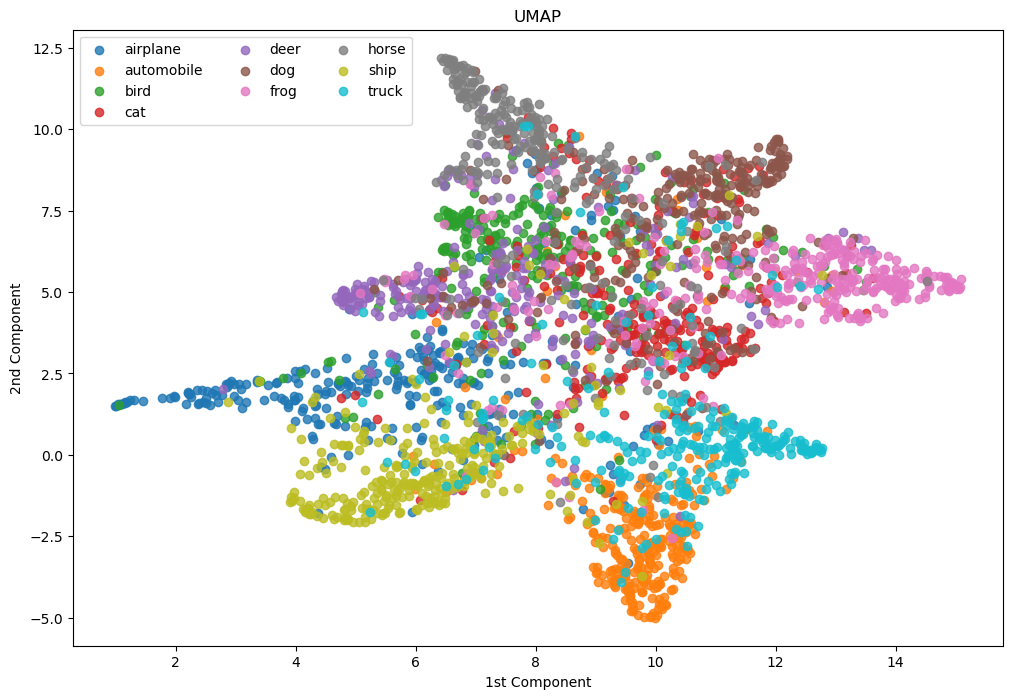

In [50]:
plot_umap(features[:3000],y_test[:3000])

### 3)

In [51]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [52]:
adverserial_transforms = transforms.Compose([transforms.ColorJitter(contrast=(0.5), hue=(-0.5,0.5)),
                                             transforms.CenterCrop(25),
                                             transforms.Resize(32),
                                             transforms.ToTensor(),transforms.Normalize(*data_statistics,inplace = True),AddGaussianNoise(0., 0.03)])

In [18]:
rawtrain_dataset = Cifar10Dataset(cifar_dataset,train_idx)
rawtest_dataset = Cifar10Dataset(cifar_dataset,test_idx)

advtrain_idx, _ = train_test_split(np.arange(len(train_classes)),test_size=0.5,shuffle=True,stratify=train_classes,random_state=SEED)
adv_dataset_train = Cifar10Dataset(rawtrain_dataset,advtrain_idx,adverserial_transforms)
advtrain_dataset = torch.utils.data.ConcatDataset([train_dataset,adv_dataset_train])

advtest_idx, _ = train_test_split(np.arange(len(test_classes)),test_size=0.5,shuffle=True,stratify=test_classes,random_state=SEED)
adv_dataset_test = Cifar10Dataset(rawtest_dataset,advtest_idx,adverserial_transforms)
advtest_dataset = torch.utils.data.ConcatDataset([test_dataset,adv_dataset_test])

'''advtrain_classes = np.array([label for _, label in advtrain_dataset])
advtest_classes = np.array([label for _, label in advtest_dataset])

advtrain_sampler = samplers.MPerClassSampler(advtrain_classes, m = 10, length_before_new_iter=len(advtrain_dataset))
advtest_sampler = samplers.MPerClassSampler(advtest_classes, m = 10, length_before_new_iter=len(advtest_dataset))'''

advtrainloader = torch.utils.data.DataLoader(advtrain_dataset, batch_size=BATCH_SIZE, shuffle= True, num_workers=2)
advtestloader = torch.utils.data.DataLoader(advtest_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

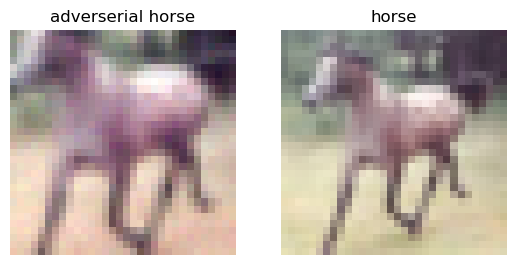

In [ ]:
img, label = adv_dataset_test[2]
img = img*0.5+0.5
plt.subplot(1,2,1)
plt.imshow(img.permute(1, 2, 0))
plt.title(f"adverserial {classes[label]}")
plt.axis("off")

plt.subplot(1,2,2)
img, label = test_dataset[advtest_idx[2]]
img = img*0.5+0.5
plt.imshow(img.permute(1, 2, 0))
plt.title(classes[label])
plt.axis("off")
plt.show();

In [63]:
def generate_fgm_examples(model,data_loader,criterion,number,miner_func = None):
    #global best_acc
    model.eval()
    advexamples = []
    labels = []
    with tqdm(data_loader) as test_tqdm:
        for batch_idx, (inputs, targets) in enumerate(test_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)
            if(random.uniform(0,1)>0.6):
                inputs = fast_gradient_method(model,inputs,0.1, np.inf)
            outputs = model(inputs)
            if(miner_func != None):
                miner_output = miner_func(outputs, targets)
                loss = criterion(outputs, targets, miner_output)
            else:
                loss = criterion(outputs, targets)
                
            for x,y in zip(inputs,targets):
                advexamples.append(x.cpu().detach().numpy())
                labels.append(y.item())

    return np.array(advexamples)[:number],np.array(labels)[:number]

In [53]:
advX_test,advy_test = generate_fgm_examples(resnet18,advtestloader,loss_func,3000)
output = resnet18_backbone(torch.tensor(advX_test).to(device))
features = np.squeeze(output.cpu().detach().numpy())

100%|██████████| 360/360 [00:38<00:00,  9.46it/s]


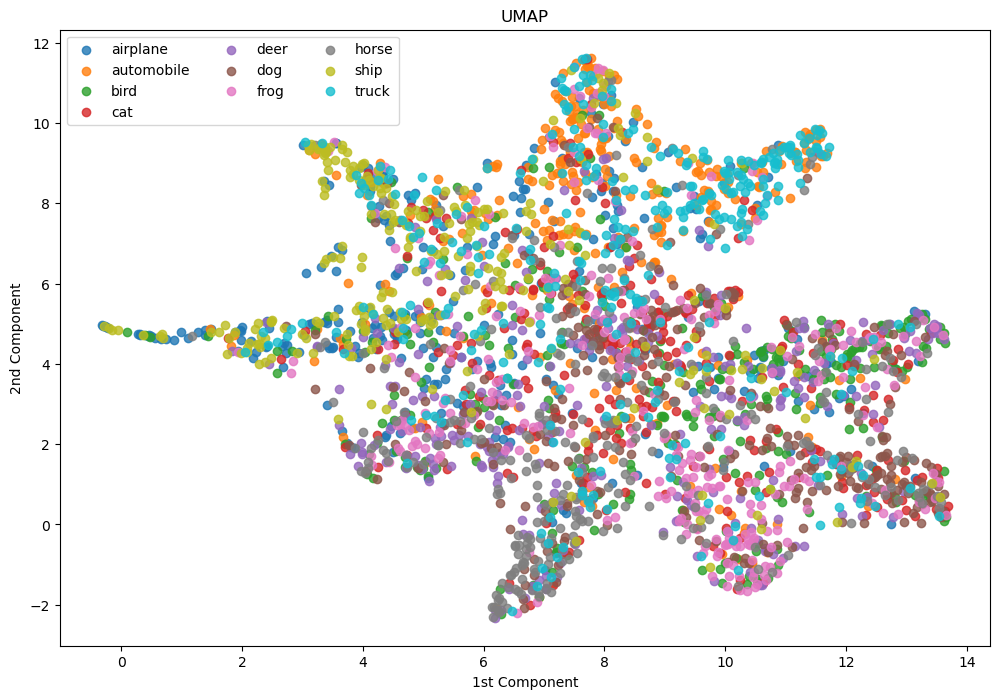

In [54]:
plot_umap(features,advy_test)

#### adverserial examples & fgm attack

In [75]:
test_loss,test_accuracy = test(model = resnet18,data_loader=advtestloader,criterion = loss_func,optimizer=optimizer,attack = True)
print(f'test loss: {test_loss}, test accuracy: {test_accuracy}')

   test: 100%|██████████| 360/360 [00:35<00:00, 10.19it/s, accuracy=36.2, loss=0.0262, total=72000]

test loss: 0.02624572848280271, test accuracy: 36.19166666666667


#### 4)

##### 2 -

In [20]:
advresnet18 = Resnet18(10,False)
advresnet18 = advresnet18.to(device)
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(advresnet18.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
train_loss,train_accuracy = train_model(advresnet18,advtrainloader,loss_func,optimizer,attack = True);

EPOCH 1/80 :


   train: 100%|██████████| 90/90 [00:20<00:00,  4.34it/s, accuracy=25.5, loss=0.0103, total=18000]


EPOCH 2/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  8.04it/s, accuracy=34.2, loss=0.00901, total=18000]


EPOCH 3/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.68it/s, accuracy=38.2, loss=0.00839, total=18000]


EPOCH 4/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.50it/s, accuracy=39.3, loss=0.0082, total=18000] 


EPOCH 5/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  7.96it/s, accuracy=44.1, loss=0.00772, total=18000]


EPOCH 6/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.27it/s, accuracy=43.7, loss=0.0076, total=18000] 


EPOCH 7/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.41it/s, accuracy=48.2, loss=0.00707, total=18000]


EPOCH 8/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  7.99it/s, accuracy=51.2, loss=0.00677, total=18000]


EPOCH 9/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.53it/s, accuracy=54.5, loss=0.00628, total=18000]


EPOCH 10/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.39it/s, accuracy=55.2, loss=0.0062, total=18000] 


EPOCH 11/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  8.09it/s, accuracy=59, loss=0.00568, total=18000]  


EPOCH 12/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.36it/s, accuracy=58.9, loss=0.0057, total=18000] 


EPOCH 13/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  7.98it/s, accuracy=64.1, loss=0.0051, total=18000] 


EPOCH 14/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.56it/s, accuracy=63.7, loss=0.00519, total=18000]


EPOCH 15/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.47it/s, accuracy=65.9, loss=0.00475, total=18000]


EPOCH 16/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  7.97it/s, accuracy=70.4, loss=0.00418, total=18000]


EPOCH 17/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.37it/s, accuracy=67.7, loss=0.00457, total=18000]


EPOCH 18/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.38it/s, accuracy=70.3, loss=0.00419, total=18000]


EPOCH 19/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  8.01it/s, accuracy=74.1, loss=0.00365, total=18000]


EPOCH 20/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.57it/s, accuracy=73, loss=0.00405, total=18000]  


EPOCH 21/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.43it/s, accuracy=72.2, loss=0.00396, total=18000]


EPOCH 22/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  8.03it/s, accuracy=76.7, loss=0.00341, total=18000]


EPOCH 23/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.54it/s, accuracy=82, loss=0.00269, total=18000]  


EPOCH 24/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.28it/s, accuracy=75.7, loss=0.00353, total=18000]


EPOCH 25/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  7.65it/s, accuracy=77.7, loss=0.00329, total=18000]


EPOCH 26/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.28it/s, accuracy=75.8, loss=0.00353, total=18000]


EPOCH 27/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.42it/s, accuracy=76.7, loss=0.00346, total=18000]


EPOCH 28/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  7.97it/s, accuracy=80.3, loss=0.00291, total=18000]


EPOCH 29/80 :


   train: 100%|██████████| 90/90 [00:12<00:00,  7.33it/s, accuracy=83, loss=0.00257, total=18000]  


EPOCH 30/80 :


   train: 100%|██████████| 90/90 [00:12<00:00,  7.03it/s, accuracy=83.2, loss=0.00253, total=18000]


EPOCH 31/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.32it/s, accuracy=83.8, loss=0.0025, total=18000] 


EPOCH 32/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.43it/s, accuracy=80.5, loss=0.00281, total=18000]


EPOCH 33/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  8.09it/s, accuracy=85.4, loss=0.00227, total=18000]


EPOCH 34/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.51it/s, accuracy=83.7, loss=0.00252, total=18000]


EPOCH 35/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.26it/s, accuracy=81.3, loss=0.00292, total=18000]


EPOCH 36/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  8.05it/s, accuracy=80.9, loss=0.00294, total=18000]


EPOCH 37/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.58it/s, accuracy=84.5, loss=0.00241, total=18000]


EPOCH 38/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.47it/s, accuracy=80.1, loss=0.00306, total=18000]


EPOCH 39/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  7.94it/s, accuracy=82.2, loss=0.00274, total=18000]


EPOCH 40/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.47it/s, accuracy=81, loss=0.003, total=18000]    


EPOCH 41/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.49it/s, accuracy=82.8, loss=0.00259, total=18000]


EPOCH 42/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  8.17it/s, accuracy=86.8, loss=0.00206, total=18000]


EPOCH 43/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.72it/s, accuracy=87.7, loss=0.00192, total=18000]


EPOCH 44/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  7.71it/s, accuracy=86, loss=0.00216, total=18000]  


EPOCH 45/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  7.95it/s, accuracy=83.4, loss=0.00258, total=18000]


EPOCH 46/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.59it/s, accuracy=82.9, loss=0.00265, total=18000]


EPOCH 47/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.81it/s, accuracy=85.4, loss=0.0022, total=18000] 


EPOCH 48/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  8.14it/s, accuracy=86.3, loss=0.00219, total=18000]


EPOCH 49/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.54it/s, accuracy=83.8, loss=0.0025, total=18000] 


EPOCH 50/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.60it/s, accuracy=84.9, loss=0.00235, total=18000]


EPOCH 51/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  8.05it/s, accuracy=85.2, loss=0.00229, total=18000]


EPOCH 52/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.74it/s, accuracy=85.2, loss=0.00228, total=18000]


EPOCH 53/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.54it/s, accuracy=81.1, loss=0.00282, total=18000]


EPOCH 54/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  8.00it/s, accuracy=84.4, loss=0.00239, total=18000]


EPOCH 55/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.44it/s, accuracy=86.9, loss=0.002, total=18000]  


EPOCH 56/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.66it/s, accuracy=87.5, loss=0.00195, total=18000]


EPOCH 57/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.19it/s, accuracy=85.3, loss=0.00227, total=18000]


EPOCH 58/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.66it/s, accuracy=83.7, loss=0.00245, total=18000]


EPOCH 59/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.62it/s, accuracy=86, loss=0.00215, total=18000]  


EPOCH 60/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  7.93it/s, accuracy=86.1, loss=0.00216, total=18000]


EPOCH 61/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.54it/s, accuracy=87.3, loss=0.00193, total=18000]


EPOCH 62/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.36it/s, accuracy=85.5, loss=0.00223, total=18000]


EPOCH 63/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.27it/s, accuracy=90.8, loss=0.00141, total=18000]


EPOCH 64/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.59it/s, accuracy=83.6, loss=0.00255, total=18000]


EPOCH 65/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.48it/s, accuracy=82.9, loss=0.00258, total=18000]


EPOCH 66/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  7.99it/s, accuracy=88.2, loss=0.00187, total=18000]


EPOCH 67/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.57it/s, accuracy=86.8, loss=0.00204, total=18000]


EPOCH 68/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.53it/s, accuracy=85.1, loss=0.00234, total=18000]


EPOCH 69/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  8.07it/s, accuracy=85, loss=0.00229, total=18000]  


EPOCH 70/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.69it/s, accuracy=86.8, loss=0.002, total=18000]  


EPOCH 71/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.70it/s, accuracy=88.6, loss=0.00177, total=18000]


EPOCH 72/80 :


   train: 100%|██████████| 90/90 [00:11<00:00,  8.16it/s, accuracy=86.5, loss=0.00213, total=18000]


EPOCH 73/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.62it/s, accuracy=83.8, loss=0.00247, total=18000]


EPOCH 74/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.57it/s, accuracy=84.8, loss=0.00227, total=18000]


EPOCH 75/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.21it/s, accuracy=89.3, loss=0.00165, total=18000]


EPOCH 76/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.62it/s, accuracy=87.5, loss=0.00193, total=18000]


EPOCH 77/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.82it/s, accuracy=88.3, loss=0.00182, total=18000]


EPOCH 78/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.27it/s, accuracy=88.7, loss=0.00173, total=18000]


EPOCH 79/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.67it/s, accuracy=85.9, loss=0.0022, total=18000] 


EPOCH 80/80 :


   train: 100%|██████████| 90/90 [00:10<00:00,  8.85it/s, accuracy=87.9, loss=0.00192, total=18000]


In [24]:
train_loss,train_accuracy = test(advresnet18,trainloader,loss_func,optimizer)
test_loss,test_accuracy =test(advresnet18,testloader,loss_func,optimizer)
print(f'train loss: {train_loss}, train accuracy: {train_accuracy}')
print(f'test loss: {test_loss}, test accuracy: {test_accuracy}')

   test: 100%|██████████| 240/240 [00:13<00:00, 17.34it/s, accuracy=55.6, loss=0.00806, total=48000]

train loss: 0.000369899021461606, train accuracy: 98.69166666666666
test loss: 0.008060717893143495, test accuracy: 55.61666666666667


In [56]:
advresnet18_backbone = advresnet18.backbone
for param in advresnet18_backbone.parameters():
    param.requires_grad = False

X_test = []
y_test = []
for x,y in test_dataset:
    X_test.append(x.cpu().detach().numpy())
    y_test.append(y)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [57]:
output = advresnet18_backbone(torch.tensor(X_test).to(device))
features = np.squeeze(output.cpu().detach().numpy())

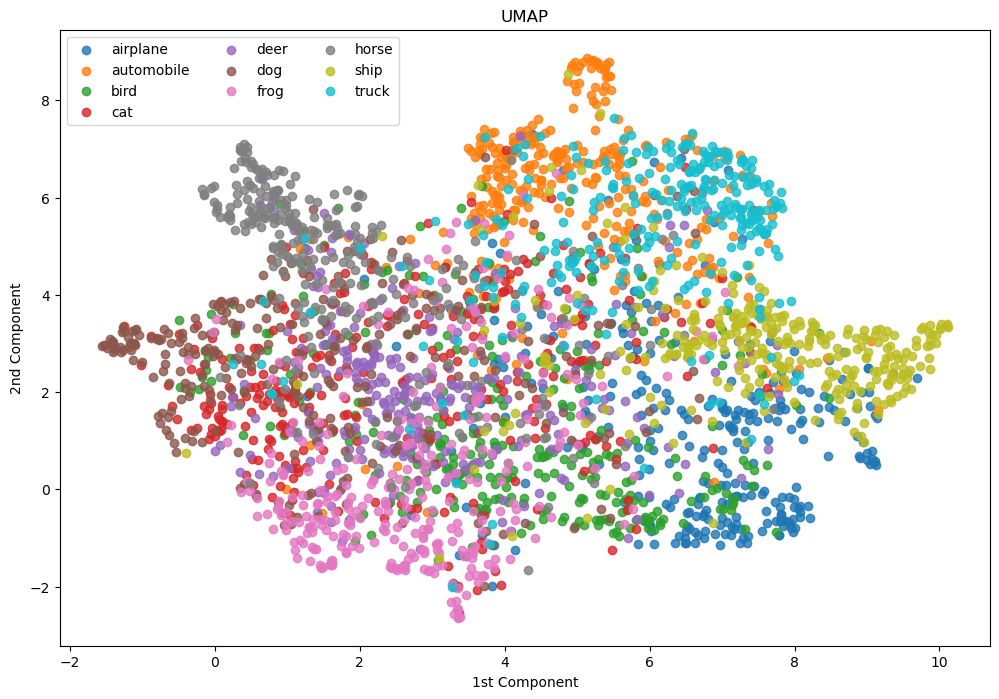

In [58]:
plot_umap(features[:3000],y_test[:3000])

#### 3-

In [64]:
advX_test,advy_test = generate_fgm_examples(advresnet18,advtestloader,loss_func,3000)
output = advresnet18_backbone(torch.tensor(advX_test).to(device))
features = np.squeeze(output.cpu().detach().numpy())

100%|██████████| 360/360 [00:37<00:00,  9.71it/s]


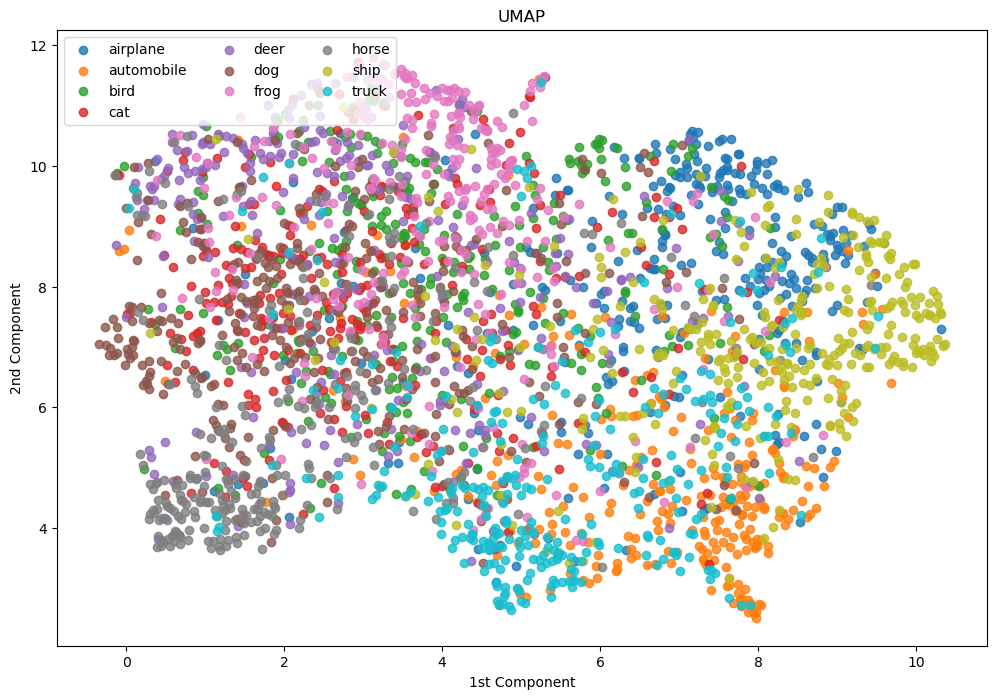

In [66]:
plot_umap(features,advy_test)

#### adverserial examples & fgm attacks

In [38]:
advtest_loss, advtest_acc = test(model = advresnet18,data_loader=advtestloader,criterion = loss_func,optimizer=optimizer,attack = True);
print(f'test loss: {advtest_loss}, test accuracy: {advtest_acc}')

   test: 100%|██████████| 360/360 [00:36<00:00,  9.99it/s, accuracy=41.4, loss=0.0118, total=72000]

test loss: 0.011799976984659831, test accuracy: 41.388888888888886


### 6)

#### 2 -

In [14]:
train_dataset = Cifar10Dataset(cifar_dataset,train_idx,cifar_transforms)
test_dataset = Cifar10Dataset(cifar_dataset,test_idx,cifar_transforms)

train_classes = np.array([label for _, label in train_dataset])
test_classes = np.array([label for _, label in test_dataset])

train_sampler = samplers.MPerClassSampler(train_classes, m = 20, length_before_new_iter=len(train_dataset))
test_sampler = samplers.MPerClassSampler(test_classes, m = 20, length_before_new_iter=len(test_dataset))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=200, shuffle=False, num_workers=2,sampler=train_sampler)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=200, shuffle=False, num_workers=2,sampler=test_sampler)

In [16]:
angresnet18 = Resnet18(64,True)
angresnet18 = angresnet18.to(device)
loss_func = losses.AngularLoss()
miner_func = miners.AngularMiner()
optimizer = torch.optim.SGD(angresnet18.parameters(), lr=0.05, momentum=0.9, weight_decay=5e-4)
train_loss,train_accuracy= train_model(angresnet18,trainloader,loss_func,optimizer,False,80,miner_func,True)

EPOCH 1/80 :


   train: 100%|██████████| 60/60 [00:20<00:00,  2.88it/s, accuracy=23.4, loss=0.0283, total=12000]


EPOCH 2/80 :


   train: 100%|██████████| 60/60 [00:25<00:00,  2.32it/s, accuracy=38.4, loss=0.0261, total=12000]


EPOCH 3/80 :


   train: 100%|██████████| 60/60 [00:16<00:00,  3.67it/s, accuracy=44.5, loss=0.0257, total=12000]


EPOCH 4/80 :


   train: 100%|██████████| 60/60 [00:15<00:00,  3.89it/s, accuracy=50, loss=0.0254, total=12000]


EPOCH 5/80 :


   train: 100%|██████████| 60/60 [00:15<00:00,  3.97it/s, accuracy=56.1, loss=0.0253, total=12000]


EPOCH 6/80 :


   train: 100%|██████████| 60/60 [00:14<00:00,  4.10it/s, accuracy=60.3, loss=0.0251, total=12000]


EPOCH 7/80 :


   train: 100%|██████████| 60/60 [00:13<00:00,  4.37it/s, accuracy=63.9, loss=0.0249, total=12000]


EPOCH 8/80 :


   train: 100%|██████████| 60/60 [00:13<00:00,  4.58it/s, accuracy=68.9, loss=0.0248, total=12000]


EPOCH 9/80 :


   train: 100%|██████████| 60/60 [00:13<00:00,  4.45it/s, accuracy=71.7, loss=0.0247, total=12000]


EPOCH 10/80 :


   train: 100%|██████████| 60/60 [00:12<00:00,  4.87it/s, accuracy=74.6, loss=0.0246, total=12000]


EPOCH 11/80 :


   train: 100%|██████████| 60/60 [00:14<00:00,  4.20it/s, accuracy=75.5, loss=0.0245, total=12000]


EPOCH 12/80 :


   train: 100%|██████████| 60/60 [00:11<00:00,  5.26it/s, accuracy=79.2, loss=0.0242, total=12000]


EPOCH 13/80 :


   train: 100%|██████████| 60/60 [00:11<00:00,  5.39it/s, accuracy=81.2, loss=0.0244, total=12000]


EPOCH 14/80 :


   train: 100%|██████████| 60/60 [00:11<00:00,  5.30it/s, accuracy=83.2, loss=0.024, total=12000]


EPOCH 15/80 :


   train: 100%|██████████| 60/60 [00:11<00:00,  5.33it/s, accuracy=84.5, loss=0.0241, total=12000]


EPOCH 16/80 :


   train: 100%|██████████| 60/60 [00:11<00:00,  5.21it/s, accuracy=85.7, loss=0.024, total=12000]


EPOCH 17/80 :


   train: 100%|██████████| 60/60 [00:11<00:00,  5.22it/s, accuracy=85.5, loss=0.024, total=12000]


EPOCH 18/80 :


   train: 100%|██████████| 60/60 [00:11<00:00,  5.42it/s, accuracy=86, loss=0.0239, total=12000]


EPOCH 19/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.99it/s, accuracy=88.3, loss=0.0237, total=12000]


EPOCH 20/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.62it/s, accuracy=88.5, loss=0.0236, total=12000]


EPOCH 21/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.56it/s, accuracy=89.7, loss=0.0237, total=12000]


EPOCH 22/80 :


   train: 100%|██████████| 60/60 [00:11<00:00,  5.21it/s, accuracy=90.1, loss=0.0234, total=12000]


EPOCH 23/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.54it/s, accuracy=90.5, loss=0.0233, total=12000]


EPOCH 24/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.95it/s, accuracy=91.3, loss=0.0233, total=12000]


EPOCH 25/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.86it/s, accuracy=91, loss=0.0231, total=12000]


EPOCH 26/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.58it/s, accuracy=91.6, loss=0.0234, total=12000]


EPOCH 27/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.63it/s, accuracy=91.9, loss=0.0232, total=12000]


EPOCH 28/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.63it/s, accuracy=92.8, loss=0.023, total=12000]


EPOCH 29/80 :


   train: 100%|██████████| 60/60 [00:11<00:00,  5.28it/s, accuracy=91.3, loss=0.0233, total=12000]


EPOCH 30/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.87it/s, accuracy=93.6, loss=0.0226, total=12000]


EPOCH 31/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.67it/s, accuracy=93, loss=0.023, total=12000]


EPOCH 32/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.69it/s, accuracy=93.6, loss=0.0228, total=12000]


EPOCH 33/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.81it/s, accuracy=92.8, loss=0.0228, total=12000]


EPOCH 34/80 :


   train: 100%|██████████| 60/60 [00:09<00:00,  6.23it/s, accuracy=94.2, loss=0.0226, total=12000]


EPOCH 35/80 :


   train: 100%|██████████| 60/60 [00:11<00:00,  5.14it/s, accuracy=94.1, loss=0.0225, total=12000]


EPOCH 36/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.70it/s, accuracy=93.7, loss=0.0226, total=12000]


EPOCH 37/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.65it/s, accuracy=94.6, loss=0.0224, total=12000]


EPOCH 38/80 :


   train: 100%|██████████| 60/60 [00:09<00:00,  6.26it/s, accuracy=93.6, loss=0.0226, total=12000]


EPOCH 39/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.76it/s, accuracy=94.5, loss=0.0227, total=12000]


EPOCH 40/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.80it/s, accuracy=94.3, loss=0.0227, total=12000]


EPOCH 41/80 :


   train: 100%|██████████| 60/60 [00:11<00:00,  5.02it/s, accuracy=94.4, loss=0.0223, total=12000]


EPOCH 42/80 :


   train: 100%|██████████| 60/60 [00:09<00:00,  6.29it/s, accuracy=94, loss=0.0226, total=12000]


EPOCH 43/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.65it/s, accuracy=95.2, loss=0.0224, total=12000]


EPOCH 44/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.70it/s, accuracy=94.8, loss=0.0222, total=12000]


EPOCH 45/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.70it/s, accuracy=95.3, loss=0.0222, total=12000]


EPOCH 46/80 :


   train: 100%|██████████| 60/60 [00:09<00:00,  6.24it/s, accuracy=94.9, loss=0.0224, total=12000]


EPOCH 47/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.57it/s, accuracy=95.3, loss=0.0226, total=12000]


EPOCH 48/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.49it/s, accuracy=95.9, loss=0.0219, total=12000]


EPOCH 49/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.69it/s, accuracy=95.5, loss=0.0223, total=12000]


EPOCH 50/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.91it/s, accuracy=95.7, loss=0.022, total=12000]


EPOCH 51/80 :


   train: 100%|██████████| 60/60 [00:09<00:00,  6.29it/s, accuracy=96.2, loss=0.0219, total=12000]


EPOCH 52/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.70it/s, accuracy=95.1, loss=0.0223, total=12000]


EPOCH 53/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.73it/s, accuracy=95.7, loss=0.0222, total=12000]


EPOCH 54/80 :


   train: 100%|██████████| 60/60 [00:11<00:00,  5.21it/s, accuracy=95.8, loss=0.0216, total=12000]


EPOCH 55/80 :


   train: 100%|██████████| 60/60 [00:09<00:00,  6.15it/s, accuracy=95.7, loss=0.0222, total=12000]


EPOCH 56/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.84it/s, accuracy=95.5, loss=0.0221, total=12000]


EPOCH 57/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.72it/s, accuracy=96.2, loss=0.0217, total=12000]


EPOCH 58/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.71it/s, accuracy=95.8, loss=0.0215, total=12000]


EPOCH 59/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.93it/s, accuracy=96.3, loss=0.022, total=12000]


EPOCH 60/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.55it/s, accuracy=96.2, loss=0.0215, total=12000]


EPOCH 61/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.70it/s, accuracy=95.9, loss=0.0216, total=12000]


EPOCH 62/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.67it/s, accuracy=95, loss=0.0225, total=12000]


EPOCH 63/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.78it/s, accuracy=96.7, loss=0.0216, total=12000]


EPOCH 64/80 :


   train: 100%|██████████| 60/60 [00:09<00:00,  6.19it/s, accuracy=96.1, loss=0.0222, total=12000]


EPOCH 65/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.91it/s, accuracy=96.2, loss=0.0217, total=12000]


EPOCH 66/80 :


   train: 100%|██████████| 60/60 [00:11<00:00,  5.37it/s, accuracy=96, loss=0.0222, total=12000]


EPOCH 67/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.56it/s, accuracy=96.5, loss=0.0215, total=12000]


EPOCH 68/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.77it/s, accuracy=96.2, loss=0.0216, total=12000]


EPOCH 69/80 :


   train: 100%|██████████| 60/60 [00:09<00:00,  6.35it/s, accuracy=94.8, loss=0.022, total=12000]


EPOCH 70/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.71it/s, accuracy=95.6, loss=0.022, total=12000]


EPOCH 71/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.77it/s, accuracy=96.5, loss=0.0218, total=12000]


EPOCH 72/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.73it/s, accuracy=96.7, loss=0.0216, total=12000]


EPOCH 73/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.56it/s, accuracy=96.4, loss=0.0216, total=12000]


EPOCH 74/80 :


   train: 100%|██████████| 60/60 [00:11<00:00,  5.41it/s, accuracy=96.6, loss=0.0218, total=12000]


EPOCH 75/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.69it/s, accuracy=96.9, loss=0.0216, total=12000]


EPOCH 76/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.71it/s, accuracy=96.4, loss=0.0214, total=12000]


EPOCH 77/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.71it/s, accuracy=96.4, loss=0.0219, total=12000]


EPOCH 78/80 :


   train: 100%|██████████| 60/60 [00:09<00:00,  6.29it/s, accuracy=96.8, loss=0.022, total=12000]


EPOCH 79/80 :


   train: 100%|██████████| 60/60 [00:11<00:00,  5.28it/s, accuracy=96.3, loss=0.0217, total=12000]


EPOCH 80/80 :


   train: 100%|██████████| 60/60 [00:10<00:00,  5.75it/s, accuracy=96.9, loss=0.0218, total=12000]


In [17]:
def fit_knn(model,train_dataset):
    X_train,y_train = [],[]
    for x,y in train_dataset:
        X_train.append(x.cpu().detach().numpy())
        y_train.append(y)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    train_map = model(torch.tensor(X_train).to(device))
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(train_map.cpu().detach().numpy(),y_train)
    return knn

def calculate_angular_accuracy(model,knn,test_dataset):
    X_test,y_test = [],[]
    for x,y in test_dataset:
        X_test.append(x.cpu().detach().numpy())
        y_test.append(y)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    test_map = model(torch.tensor(X_test).to(device))
    pred = knn.predict(test_map.cpu().detach().numpy())
    accuracy = accuracy_score(pred,y_test)
    return accuracy

In [18]:
for param in angresnet18.parameters():
    param.requires_grad = False
knn = fit_knn(angresnet18,train_dataset)

In [19]:
train_accuracy = calculate_angular_accuracy(angresnet18,knn,train_dataset)
test_accuracy = calculate_angular_accuracy(angresnet18,knn,test_dataset)
print(f'train accuracy: {train_accuracy}')
print(f'test accuracy: {test_accuracy}')

train accuracy: 0.9684166666666667

test accuracy: 0.6193125


In [29]:
angresnet18_backbone = angresnet18.backbone
for param in angresnet18_backbone.parameters():
    param.requires_grad = False

X_test = []
y_test = []
for x,y in test_dataset:
    X_test.append(x.cpu().detach().numpy())
    y_test.append(y)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
output = angresnet18_backbone(torch.tensor(X_test).to(device))
features = np.squeeze(output.cpu().detach().numpy())

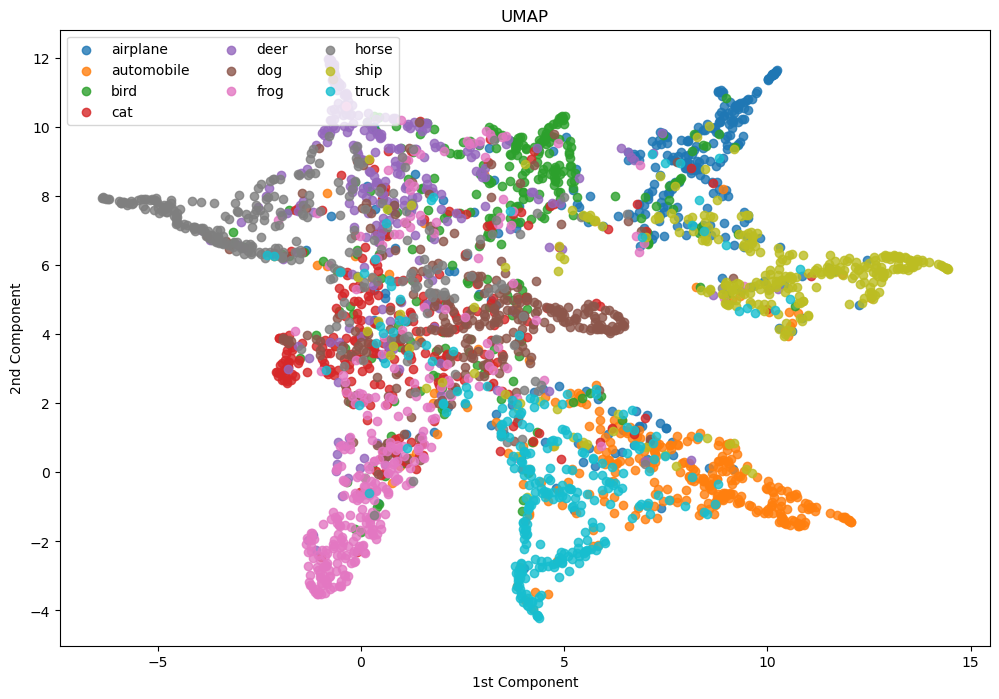

In [ ]:
plot_umap(features[:3000],y_test[:3000])

#### 3-

In [56]:
rawtest_dataset = Cifar10Dataset(cifar_dataset,test_idx)

advtest_idx, _ = train_test_split(np.arange(len(test_classes)),test_size=0.5,shuffle=True,stratify=test_classes,random_state=SEED)
adv_dataset_test = Cifar10Dataset(rawtest_dataset,advtest_idx,adverserial_transforms)
advtest_dataset = torch.utils.data.ConcatDataset([test_dataset,adv_dataset_test])

advtest_dataset_labels = np.array([label for _, label in advtest_dataset])

ang_sampler = samplers.MPerClassSampler(advtest_dataset_labels, m = 20, length_before_new_iter=len(advtest_dataset))
ang_advtestloader = torch.utils.data.DataLoader(advtest_dataset, batch_size=200, num_workers=2,sampler = ang_sampler)
advX_test,advy_test = generate_fgm_examples(angresnet18,ang_advtestloader,loss_func,len(advtest_dataset),miner_func = miner_func)

100%|██████████| 360/360 [00:59<00:00,  6.04it/s]


In [58]:
output = angresnet18_backbone(torch.tensor(advX_test[:3000]).to(device))
features = np.squeeze(output.cpu().detach().numpy())

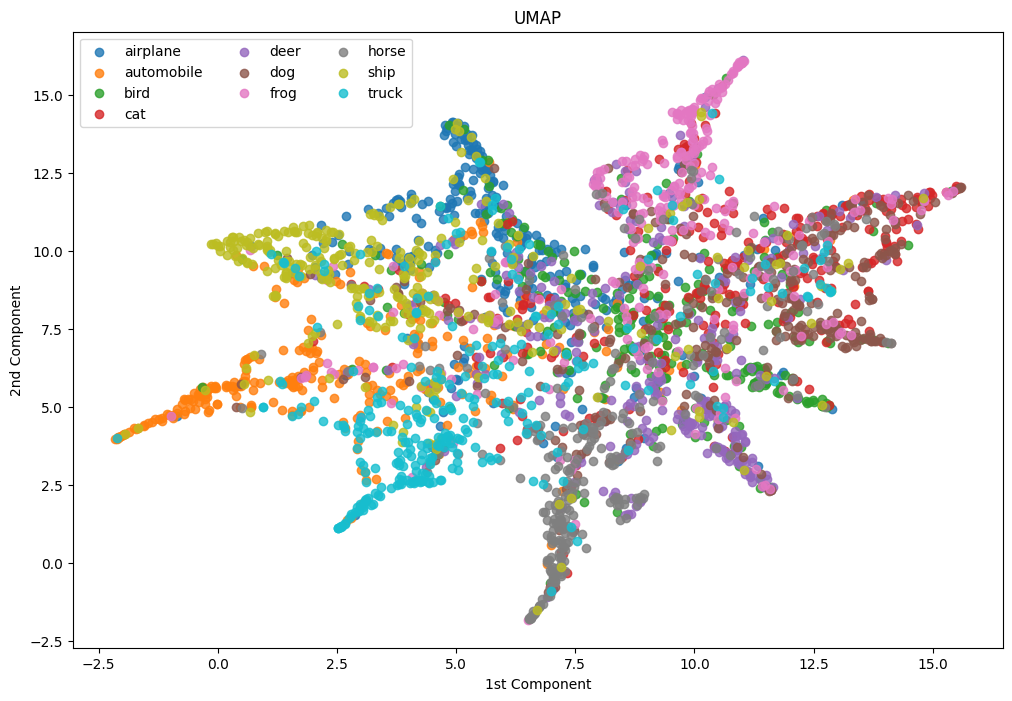

In [60]:
plot_umap(features[:3000],advy_test[:3000])

#### adverserial examples & fgm

In [46]:
correct = 0
for i in range(0,len(advy_test),6000):
  test_map = angresnet18(torch.tensor(advX_test[i:i+6000]).to(device))
  pred = knn.predict(test_map.cpu().detach().numpy())
  correct = correct + (pred == advy_test[i:i+6000]).sum()
accuracy = correct / len(advy_test)
print(f'test accuracy: {accuracy}')

test accuracy: 0.45268055555555553
